# Real-World Example: Tehran House Price Prediction 

### For this section, we will use regression to predict house prices in different regions of Tehran. The [Dataset](https://www.kaggle.com/datasets/mokar2001/house-price-tehran-iran) used is records on Divar website.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

In [18]:
! pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
file_path = 'C:/Users/golde/OneDrive/Desktop/learning/Introduction_to_Machine_Learning/Chapter_01_Supervised_Learning/assets/housePrice.xlsx'
df = pd.read_excel(file_path)

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,PriceUSD
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [4]:
print(df['Area'].describe())
print(df[df['Area'] > 1e6])

count    3.479000e+03
mean     8.744000e+06
std      3.167266e+08
min      3.000000e+01
25%      6.900000e+01
50%      9.000000e+01
75%      1.200000e+02
max      1.616000e+10
Name: Area, dtype: float64
             Area  Room  Parking  Warehouse  Elevator            Address  \
570    3310000000     2     True       True      True        Ostad Moein   
709   16160000000     3     True       True      True           Pasdaran   
1604   8400000000     2     True       True      True         Gheitarieh   
2802   2550000000     2     True       True      True  Central Janatabad   

            Price   PriceUSD  
570    3310000000  110333.33  
709   16160000000  538666.67  
1604   8700000000  290000.00  
2802   2550000000   85000.00  


In [6]:
# Data cleaning - removing outliers based on IQR
Q1_area = df['Area'].quantile(0.25)
Q3_area = df['Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

Q1_price = df['PriceUSD'].quantile(0.25)
Q3_price = df['PriceUSD'].quantile(0.75)
IQR_price = Q3_price - Q1_price


lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

df_cleaned = df[(df['Area'] >= lower_bound_area) & (df['Area'] <= upper_bound_area) &
                (df['PriceUSD'] >= lower_bound_price) & (df['PriceUSD'] <= upper_bound_price)]


#check the cleaned dataset
df_cleaned.describe()

,Area,Room,Price,PriceUSD
count,3112.000000,3112.000000,3.112000e+03,3112.000000
mean,90.353470,1.948265,3.393833e+09,113127.752988
std,30.790158,0.638090,2.844133e+09,94804.436318
min,30.000000,0.000000,3.600000e+06,120.000000
25%,66.000000,2.000000,1.250000e+09,41666.670000
50%,86.000000,2.000000,2.450000e+09,81666.670000
75%,109.000000,2.000000,4.500000e+09,150000.000000
max,192.000000,5.000000,1.282500e+10,427500.000000


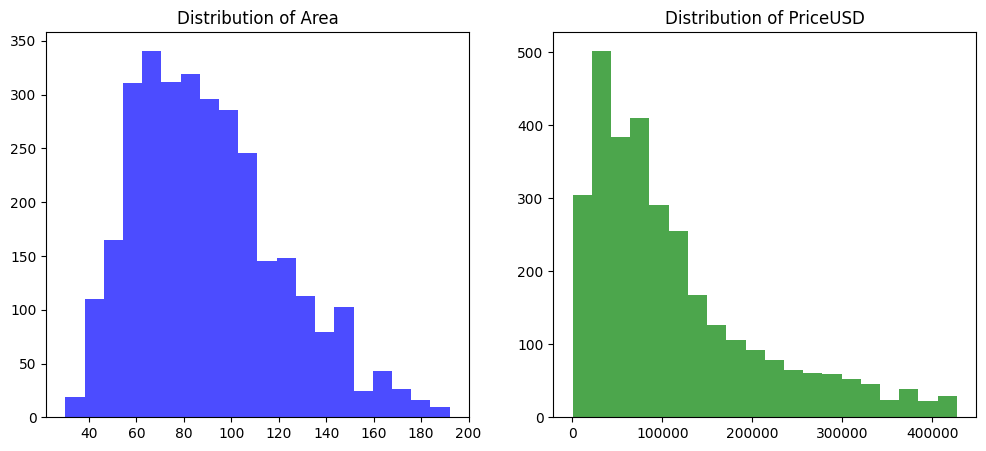

In [7]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(df_cleaned['Area'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Area')

plt.subplot(1,2,2)
plt.hist(df_cleaned['PriceUSD'], bins=20, color='green', alpha=0.7)
plt.title('Distribution of PriceUSD')

plt.show()

In [8]:
# Function to compute the Root Mean Squared Error (RMSE)
def compute_rms_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to creat polynomial features
def polynomial_features(X, degree):
    poly = PolynomialFeatures(degree=degree)
    return poly.fit_transform(X)

# Function to perform polynomial regression
def polynomial_regression(X, y, degree):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly,y)
    return model

In [12]:
# Group by 'Address' and perform analysis for each region
addresses = df_cleaned['Address'].unique() 

for address in addresses:
    df_address = df_cleaned[df_cleaned['Address'] == address]

    # Skip if not enough data points
    if len(df_address) < 2:
        print(f"Skipping address {address} due to insufficient samples")
        continue

    X = df_address[['Area']]
    y = df_address['PriceUSD']

    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=42)

    # Skip if train or test sets are empty
    if len(X_train) < 50 or len(X_test) < 25 :
        print(f"Skipping address {address} due to train-test split issues")
        continue
    else:
        print(f"Processing address: {address}")
    
    # Set polynomial degrees to evaluate
    degrees = [2, 3, 5, 8, 10]

    train_rms_errors = []
    test_rms_errors = []

    for degree in degrees:
        model = polynomial_regression(X_train, y_train, degree)

        X_train_poly = polynomial_features(X_train, degree)
        y_train_pred = model.predict(X_train_poly)

        X_test_poly = polynomial_features(X_test, degree)
        y_test_pred = model.predict(X_test_poly)
        train_rms_error = compute_rms_error(y_train, y_train_pred)
        test_rms_error = compute_rms_error(y_test, y_test_pred)

        train_rms_errors.append(train_rms_error)
        test_rms_errors.append(test_rms_error)



Processing address: Shahran
Processing address: Pardis
Skipping address Shahrake Qods due to train-test split issues
Skipping address Shahrake Gharb due to train-test split issues
Skipping address North Program Organization due to train-test split issues
Skipping address Andisheh due to train-test split issues
Processing address: West Ferdows Boulevard
Skipping address Narmak due to train-test split issues
Skipping address Saadat Abad due to train-test split issues
Skipping address Zafar due to train-test split issues
Skipping address Islamshahr due to train-test split issues
Skipping address Pirouzi due to train-test split issues
Skipping address Shahrake Shahid Bagheri due to train-test split issues
Skipping address Moniriyeh due to train-test split issues
Skipping address Amirieh due to train-test split issues
Skipping address Southern Janatabad due to train-test split issues
Skipping address Salsabil due to train-test split issues
Skipping address Zargandeh due to train-test split 